In [8]:
from duckduckgo_search import duckduckgo_search
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    searcher = duckduckgo_search.DDGS()
    
    return L(searcher.images(term, size="Medium", max_results=max_images)).itemgot('image')

In [9]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://images.hdqwalls.com/wallpapers/colorful-parrot-bird.jpg'

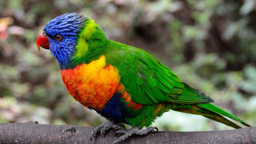

In [10]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'forest photos'


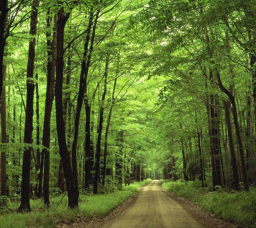

In [12]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [13]:
searches = ['bird', 'forest']
path = Path('./data')
test_set = Path('./test')
from time import sleep
import os
import shutil

if path.exists():
    shutil.rmtree(path)


for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'bird'


/home/chrisjpalmer/miniconda3/envs/fastai/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Searching for 'forest'


In [14]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

In [16]:
if test_set.exists():
    shutil.rmtree(test_set)

# move some to the test set
for o in searches:
    imgs = get_image_files(path/o)
    test_no = round(len(imgs) * 0.2)
    testimgs = imgs[:test_no]
    for img in testimgs:
        dest = Path('./test')/img
        dest.mkdir(exist_ok=True, parents=True)
        shutil.move(img, dest)

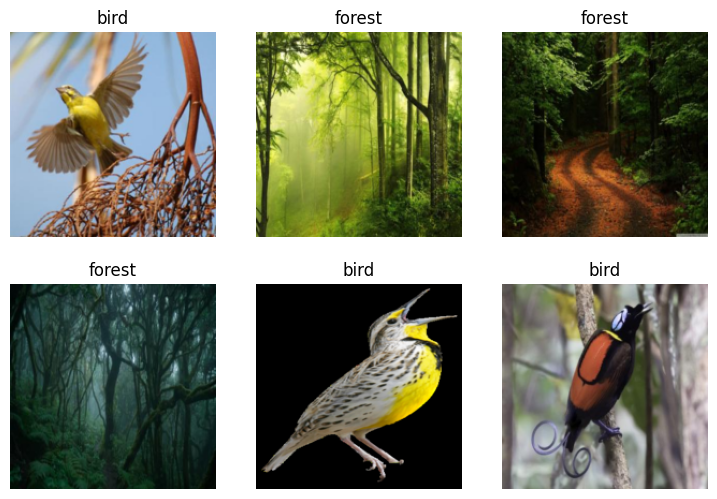

In [17]:
from duckduckgo_search import duckduckgo_search
from fastcore.all import *
from fastai.vision.all import *

path = Path('./data')
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [18]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.759667,0.699188,0.375000,00:00


/home/chrisjpalmer/miniconda3/envs/fastai/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/chrisjpalmer/miniconda3/envs/fastai/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,1.139343,0.446726,0.375000,00:00
1,0.859518,0.253812,0.125000,00:00
2,0.655298,0.107244,0.000000,00:00
3,0.508370,0.042726,0.000000,00:00
4,0.405458,0.016657,0.000000,00:00
5,0.338919,0.006370,0.000000,00:00
6,0.287814,0.003063,0.000000,00:00
7,0.252148,0.001697,0.000000,00:00
8,0.221874,0.001115,0.000000,00:00
9,0.198601,0.000863,0.000000,00:00


In [19]:
from torch.nn.modules.container import Sequential
from jaxconv import convert_pytnn_to_jax
import jax.numpy as jnp
from penzai import pz

m: Sequential = learn.model

with pz.ts.active_autovisualizer.set_scoped(pz.ts.ArrayAutovisualizer(prefers_column="x", prefers_row="y")):
  pz.ts.display(m)

_, params = convert_pytnn_to_jax(m)

def normalize_params(params):
  out_params = ()
  for p in params:
    p: jnp.ndarray
    if len(p.shape) == 4:
      p = pz.nx.wrap(p, "out_features", "in_features", "x", "y")
    out_params += (p,)
  return out_params

params = normalize_params(params)
with pz.ts.active_autovisualizer.set_scoped(pz.ts.ArrayAutovisualizer(prefers_column="x", prefers_row="y")):
  pz.ts.display(params)

/home/chrisjpalmer/miniconda3/envs/fastai/lib/python3.12/site-packages/torch/_functorch/deprecated.py:104: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional_with_buffers is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional_with_buffers', 'torch.func.functional_call')


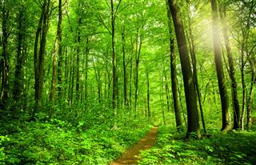

This is forest.
Probability it's a bird 0.0001
Probability it's a forest 0.9999


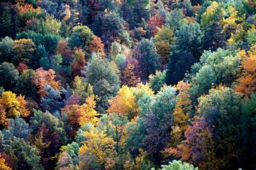

This is forest.
Probability it's a bird 0.0006
Probability it's a forest 0.9994


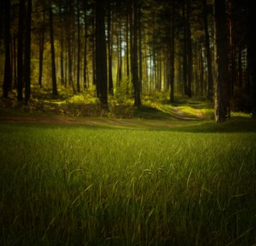

This is forest.
Probability it's a bird 0.0000
Probability it's a forest 1.0000


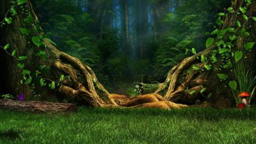

This is forest.
Probability it's a bird 0.2264
Probability it's a forest 0.7736


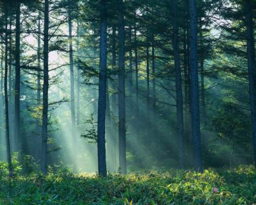

This is forest.
Probability it's a bird 0.0000
Probability it's a forest 1.0000


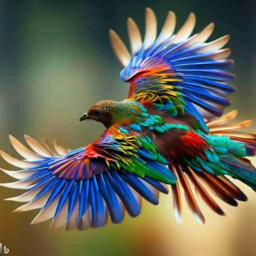

This is bird.
Probability it's a bird 0.9997
Probability it's a forest 0.0003


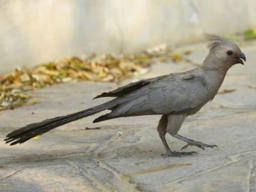

This is bird.
Probability it's a bird 1.0000
Probability it's a forest 0.0000


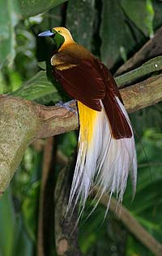

This is bird.
Probability it's a bird 1.0000
Probability it's a forest 0.0000


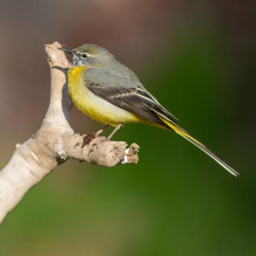

This is bird.
Probability it's a bird 1.0000
Probability it's a forest 0.0000


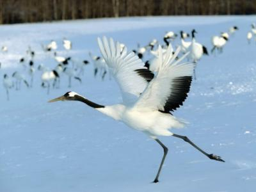

This is bird.
Probability it's a bird 1.0000
Probability it's a forest 0.0000


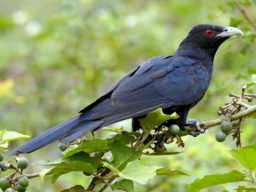

This is bird.
Probability it's a bird 1.0000
Probability it's a forest 0.0000


In [20]:
test_set = Path('./test')
files = get_image_files(test_set)

for imgpath in get_image_files(test_set):
    img = PILImage.create(imgpath)
    category,_,probs = learn.predict(img)
    
    im = Image.open(imgpath)
    display( im.to_thumb(256,256))
    print(f"This is {category}.")
    print(f"Probability it's a bird {probs[0]:.4f}")
    print(f"Probability it's a forest {probs[1]:.4f}")